In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import random
import os
import datetime


import gym

import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

cmap = plt.get_cmap("tab20")

In [4]:
# set seed
seed = 123
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
from common import experiments_kalbhairav as experiments
from common import common_fn, env_lib, wrappers
from common.dqn_model import DQN, DuelingDQN, TargetNet
from common.common_fn import Experience

In [6]:
experiment = "kb-utility-check"#args.experiment
params = experiments.EXP_PARAMS[experiment]
print("EXPERIMENT: ", experiment)

EXPERIMENT:  kb-utility-check


In [7]:
def wrap_all(env):
    env = wrappers.symmetric_normalize_obs(env)
#     env = wrappers.high_negative_reward(env)
#     env = wrappers.sparse_reward_v3(env)
    return env

In [8]:
# Create environment
env = eval("env_lib."+params['env_name']+'()')
env = wrap_all(env)

In [9]:
# evaluate Q-values of random states
NO_OF_STATES_TO_EVALUATE = 1000 # how many states to sample to evaluate
EVAL_FREQ = 240 # how often to evaluate

# n-step rollout
ROLLOUT_STEPS = params['rollout_steps']

# Width of NN
NN_LAYER_WIDTH = params['nn_layer_width']

# Double DQN flag
DOUBLE = params['double_q']

# Dueling Networks
DUELING = params['dueling']

# set device
USE_GPU = True#args.cuda
USE_CUDA = torch.cuda.is_available() and USE_GPU
device = torch.device("cuda" if USE_CUDA else "cpu")
if USE_CUDA:
    print("DEVICE #", device, ": ", torch.cuda.get_device_name(device))

DEVICE # cuda :  GeForce RTX 2080 SUPER


In [10]:
tag = experiment
nstep_tag = str(params['rollout_steps'])+"step"
tag = experiment + '-' + nstep_tag  # nstep rollouts
# if DOUBLE:
#     double_tag = 'double'
#     tag = tag + '-' + double_tag # double dqn

# if DUELING:
#     dueling_tag = 'dueling'
#     tag = tag + '-' + dueling_tag # double dqn

tag = tag + '-' + str(seed) # seed
tag = tag + '-' + datetime.datetime.now().strftime("%d_%b-%H_%M_%S")
print("TAG: ",tag)
writer_folder = './runs/'+ experiment + "/" + tag
writer = SummaryWriter(log_dir=writer_folder)

TAG:  kb-utility-check-1step-123-18_Mar-14_15_38


In [11]:
if DUELING:
    policy_net = DuelingDQN(env.observation_space.shape[0],
                               env.action_space.n,
                               NN_LAYER_WIDTH).to(device)
    
else:
    policy_net = DQN(env.observation_space.shape[0], 
                        env.action_space.n,
                        NN_LAYER_WIDTH).to(device)

    
target_net = TargetNet(policy_net)
target_net.sync()

In [12]:
buffer = common_fn.nstep_ExperienceBuffer(params['replay_size'],
                                nsteps=params['rollout_steps'],
                                gamma=params['gamma'])
optimizer = optim.Adam(policy_net.parameters(), lr=params['learning_rate'])



ITERATION:  1 / 1


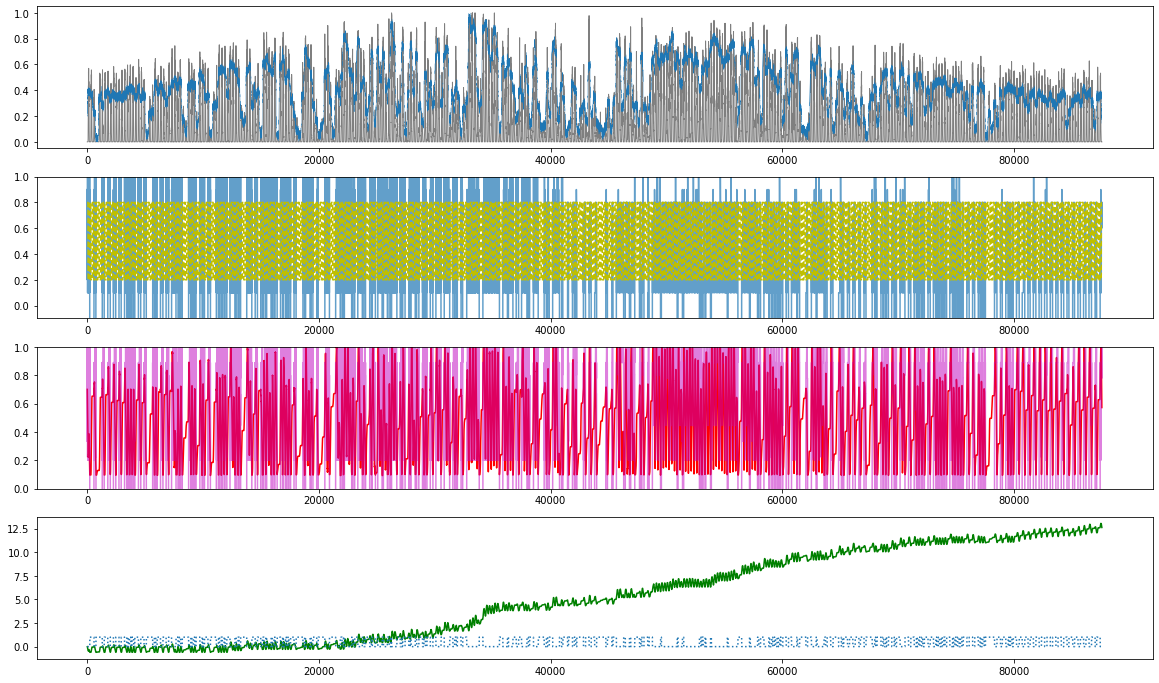

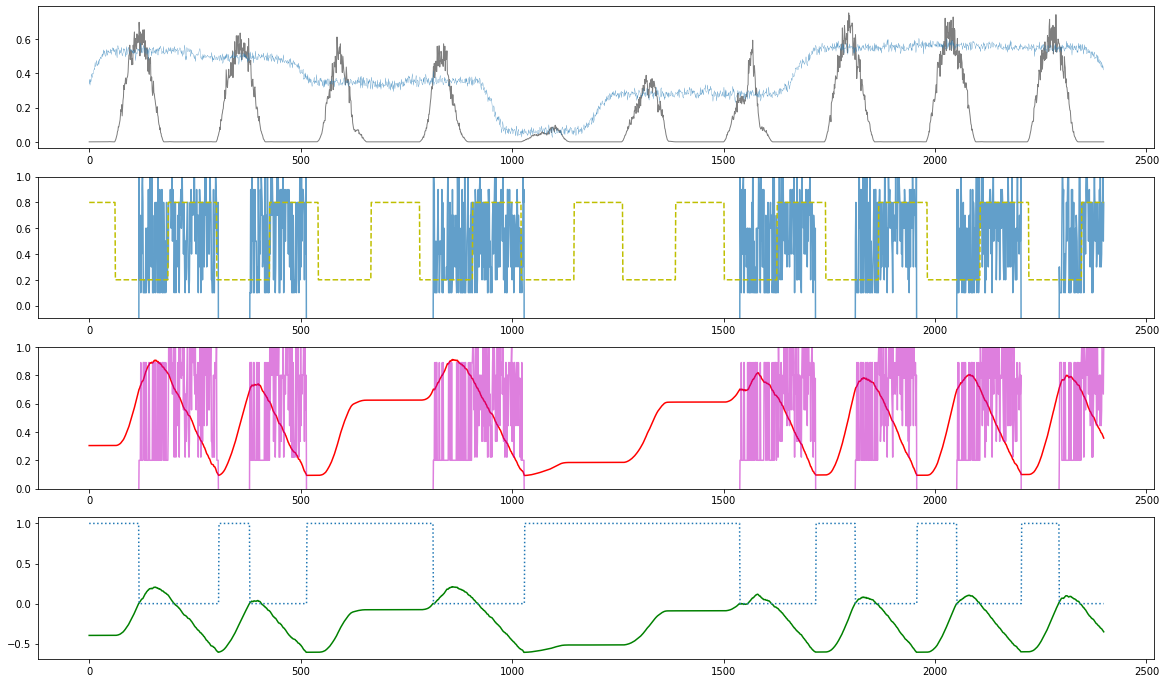

AVG REWARD:	 -0.06062644758505394
ENERGY PERF:	 12.617433747249878
RECOVERY(DAYS):	 176.1
TIME ELAPSED:	 0:05:15.551486


In [13]:
train_location = 'tokyo'
train_year = 1995
epsilon = params['epsilon_start']
frame_idx = 0
NO_OF_ITERATIONS = 1

for iteration in range(NO_OF_ITERATIONS):
    start_time = datetime.datetime.now()
    print("\n\nITERATION: ",iteration+1,"/",NO_OF_ITERATIONS)
    
    # FOR EACH ITERATION
    eval_states = None # will be populated with held-out states

    reward_rec = []
    RECOVERY_rec = []

    state = env.reset(location=train_location, 
                      year=train_year,
                      LOG_DATA=True)
    is_done = False
    present_day = -1
    while not is_done:
        # Check if day has changed
        if env.env_harvester.day != present_day:
            print("DAY: ", env.env_harvester.day, end='\r')
            present_day = env.env_harvester.day
        
        # Increase frame count
        frame_idx += 1
        
        # Log RECOVERY MODE
        RECOVERY_rec.append(env.RECOVERY_MODE)
        
        # No action/training if in RECOVERY MODE
        if env.RECOVERY_MODE:
            _, reward, is_done, _ = env.step(-1)        

        else:
            # Get epsilon
            epsilon = max(params['epsilon_final'], params['epsilon_start'] - frame_idx / params['epsilon_frames'])
            writer.add_scalar("epsilon", epsilon, frame_idx)

            # Get action
            if np.random.random() < epsilon: # random exploratory action
                action = np.random.randint(env.action_space.n)
            else: # greedy action
                with torch.no_grad():
                    state_v = torch.tensor(np.array(state, copy=False)).unsqueeze(dim=0).to(device) # convert to torch tensor
                    q_vals_v = policy_net(state_v) # get Q-values
                    _, action_idx = torch.max(q_vals_v, dim=1) # Argmax Q-values and extract action
                    action = int(action_idx.item()) # convert from torch to python variable

            # do step in the environment
            new_state, reward, is_done, _ = env.step(action)
            
            # Record experience
            exp = Experience(state, action, reward, is_done, new_state)
            buffer.append(exp)
            state = new_state

        # Record reward
        reward_rec.append(reward)
#             mean_reward = np.mean(reward_rec[-240:]) # mean of last 100 episodes
#             writer.add_scalar("Reward/reward_day", mean_reward, frame_idx)
        writer.add_scalar("Reward/reward", reward, frame_idx)

        


        # Is buffer filled enough to start training?
        if len(buffer) < params['replay_initial']:
            continue 
        # Train
        optimizer.zero_grad()
        batch = buffer.sample(params['batch_size'])
        loss_v = common_fn.calc_loss(batch, 
                                      policy_net, 
                                      target_net.target_model, 
                                      gamma=params['gamma']**ROLLOUT_STEPS,
                                      device=device,
                                      double=DOUBLE)
        loss_v.backward()
        optimizer.step()

        # Record loss
        if frame_idx % 1E3 == 0:
            writer.add_scalar("loss", loss_v, frame_idx)

        # Sync policy_net and target_net
        if frame_idx % params['target_net_sync'] == 0:
            target_net.sync()
        
        # evaluate states
        if frame_idx % EVAL_FREQ == 0:
            eval_states = buffer.sample(1000)[0]
            mean_val = common_fn.calc_values_of_states(eval_states, policy_net, device=device)
            writer.add_scalar("values_mean", mean_val, frame_idx)

        # env ends
        ########################################################
    
    common_fn.display_env_log_utility(env,
                reward_rec, 
                RECOVERY_rec,
                START_DAY=0, 
                NO_OF_DAY_TO_PLOT = 400)
    common_fn.display_env_log_utility(env,
                reward_rec, 
                RECOVERY_rec,
                START_DAY=40, 
                NO_OF_DAY_TO_PLOT = 10)
    
    print("AVG REWARD:\t", np.mean(reward_rec))
    print("ENERGY PERF:\t", np.array(env.eno_log).cumsum()[-1])
    print("RECOVERY(DAYS):\t", np.count_nonzero(RECOVERY_rec)/len(env.env_timeslot_values))
    print("TIME ELAPSED:\t",  datetime.datetime.now()  - start_time)
    # training iteration ends
    ########################################################
writer.flush()
writer.close()

In [14]:
# Save agent
import os.path
cur_folder = os.getcwd()
model_folder = os.path.join(cur_folder,"models")
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

model_file = os.path.join(model_folder, (tag + ".pt"))
torch.save(policy_net.state_dict(), model_file)



TEST YEAR: 1995


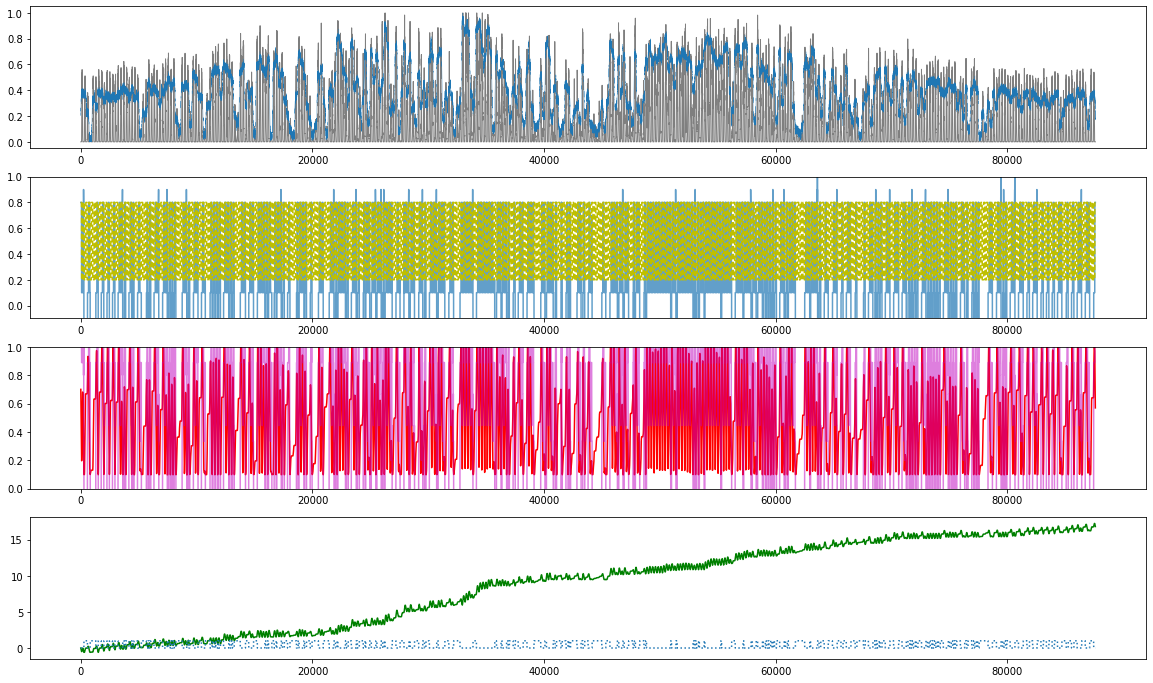

AVG REWARD:	 -0.06062644758505394
ENERGY PERF:	 12.617433747249878
RECOVERY(DAYS):	 176.1


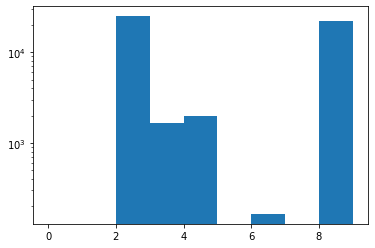

In [15]:
# Enjoy trained agent
test_location = 'tokyo'
test_year = 2000
for test_year in [1995]:
    print("\n\nTEST YEAR:", test_year)
    test_env = eval("env_lib."+params['env_name']+'()')
    test_env = wrap_all(test_env)

    test_reward_rec = []
    test_RECOVERY_rec = []

    obs = test_env.reset(location=test_location,
                    year=test_year,
                    LOG_DATA=True)

    DAYS_TO_ITERATE = 400
    done = False

    while not done:
        state_v = torch.tensor(np.array(obs, copy=False)).unsqueeze(dim=0)
        q_vals = policy_net(state_v.to(device)).data.cpu().numpy()[0]
        action = np.argmax(q_vals)
        obs, reward, done, info = test_env.step(action)
        test_reward_rec.append(reward)
        test_RECOVERY_rec.append(test_env.RECOVERY_MODE)

    common_fn.display_env_log_utility(test_env,
                    test_reward_rec, 
                    test_RECOVERY_rec,
                    START_DAY=0, 
                    NO_OF_DAY_TO_PLOT = 500)
    
    print("AVG REWARD:\t", np.mean(reward_rec))
    print("ENERGY PERF:\t", np.array(env.eno_log).cumsum()[-1])
    print("RECOVERY(DAYS):\t", np.count_nonzero(RECOVERY_rec)/len(env.env_timeslot_values))

    actions_rec = np.floor(np.array(test_env.action_log)*10+1)
    plt.hist(actions_rec,bins=np.arange(test_env.action_space.n))
    plt.yscale("log")
    plt.show()

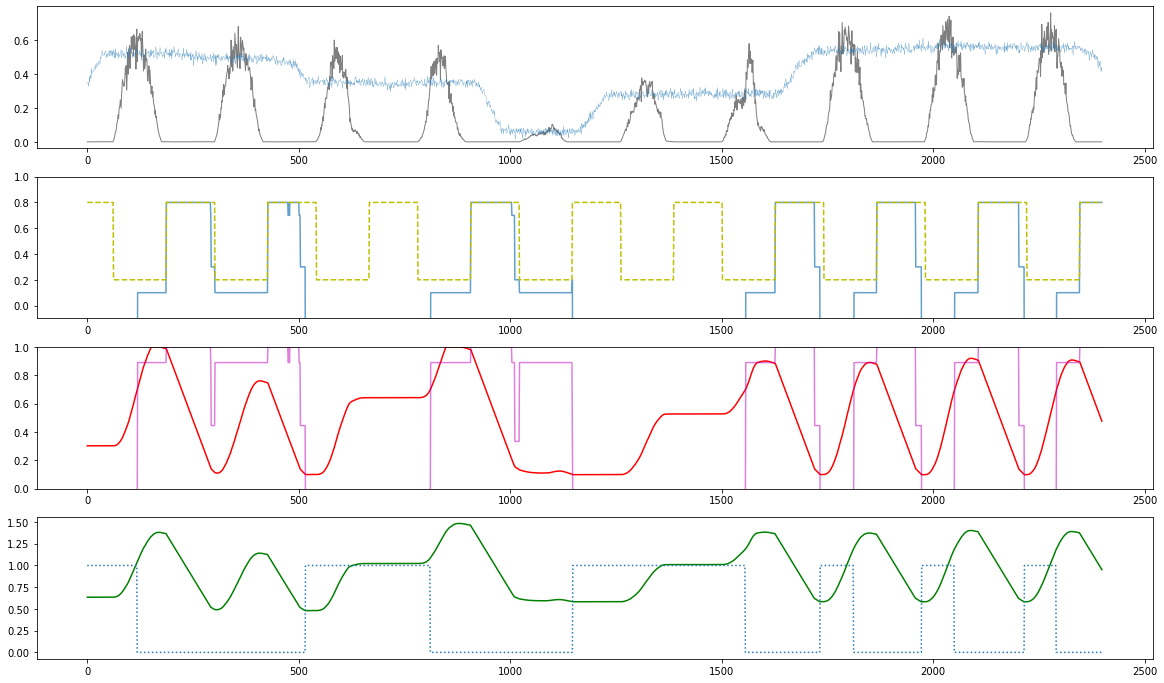

In [16]:
common_fn.display_env_log_utility(test_env,
                test_reward_rec, 
                test_RECOVERY_rec,
                START_DAY=40, 
                NO_OF_DAY_TO_PLOT = 10)